In [49]:
# 代码运行环境
# Author: M. Tong <demon386@gmail.com>
%load_ext watermark
%watermark -p torch,numpy,sklearn -v -m

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
CPython 3.6.3
IPython 6.2.1

torch 0.2.0
numpy 1.13.3
sklearn 0.19.1

compiler   : GCC 7.2.0
system     : Linux
release    : 4.13.12-1-ARCH
machine    : x86_64
processor  : 
CPU cores  : 12
interpreter: 64bit


In [6]:
%matplotlib inline

In [7]:
import numpy as np
import matplotlib.pyplot as plt

$E_{out} (g^{(D)}) = E_x[(g^{(D)} - f(x))^2]$

- $f(x)$: real distribution. Here we assume it's $y = x + noise$. $x \sim Uniform(0, 19)$, assume that noise is fixed so that $f(x)$ is determinisitic

In [38]:
def f(x):
    return x + np.random.normal(size=x.shape)

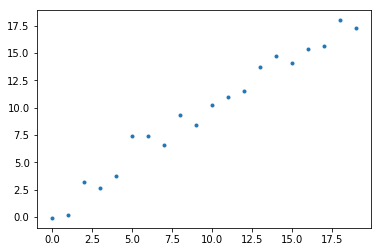

In [41]:
x = np.arange(20)
f_x = f(x)
plt.plot(x, f_x, '.');

- $g^{(D)}$: learned hypothesis from a fixed number dataset

In [42]:
d_x = np.random.choice(x, 2, replace=True)
d_y = f_x[d_x]

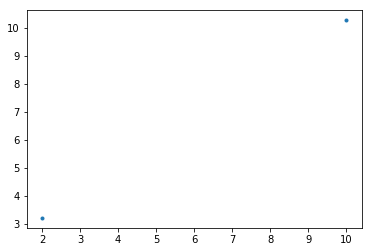

In [43]:
plt.plot(d_x, d_y, '.');

$E_{out} (g^{(D)}) = E_x[(g^{(D)} - f(x))^2]$ for this particular dataset

In [29]:
from sklearn.linear_model import LinearRegression

In [54]:
m = LinearRegression()
m.fit(d_x[:, np.newaxis], d_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [55]:
pred = m.predict(x[:, np.newaxis])

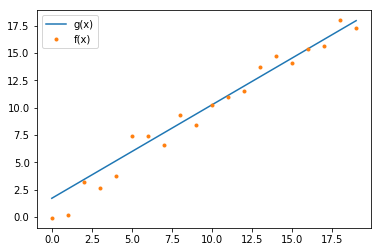

In [56]:
plt.plot(x, pred, x, f_x, '.')
plt.legend(['g(x)', 'f(x)']);

$E_{out} (g^{(D)}) = E_x[(g^{(D)} - f(x))^2]$

In [57]:
((pred - f_x) ** 2).mean()

1.1264579178828598

$E_{out}$ is the out-of-sample error for this particular hypothesis, and we want to evaluate the learning algorithm's overall performance on $D$, thus

$E_D[E_{out} (g^{(D)})] = E_D[E_x[(g^{(D)} - f(x))^2]]$

In [85]:
def error_over_D(model, data_num):
    mean_square_over_D = []
    # We use simulation to approximate expectation over D
    for i in range(10000):
        d_x = np.random.choice(x, data_num, replace=True)
        d_y = f_x[d_x]
        model.fit(d_x[:, np.newaxis], d_y)
        pred = model.predict(x[:, np.newaxis])
        mean_square = ((pred - f_x) ** 2).mean()
        mean_square_over_D.append(mean_square)
    return np.mean(mean_square_over_D)

In [78]:
from sklearn.svm import SVR

In [86]:
data_num = 2
print("Error over D for linear regression: %f" % error_over_D(LinearRegression(), data_num))
print("Error over D for SVM Regression: %f" % error_over_D(SVR(kernel='linear'), data_num))

Error over D for linear regression: 19.418551
Error over D for SVM Regression: 12.310735


So SVM outperforms when seeing sampling only two data points

In [88]:
data_num = 8
print("Error over D for linear regression: %f" % error_over_D(LinearRegression(), data_num))
print("Error over D for SVM Regression: %f" % error_over_D(SVR(kernel='linear'), data_num))

Error over D for linear regression: 1.135086
Error over D for SVM Regression: 1.372207


When seeing more data points, the error decreases and Linear regression seems to outperform.

Conclusion: $E_D[E_{out} (g^{(D)})]$ is influenced by number of samples

In [89]:
import scipy

In [138]:
x = np.arange(-1, 1, 0.01)
y = scipy.sin(np.pi * x)

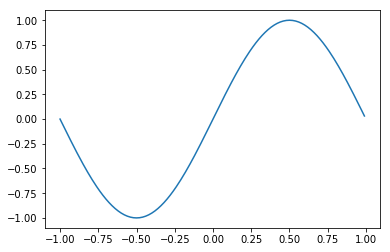

In [139]:
plt.plot(x, y)

In [140]:
h0_all = []
h1_all = []
for i in range(2000):
    d_x = np.random.choice(x, 2, replace=True)
    d_y = scipy.sin(np.pi * d_x)
    h0 = np.polyfit(d_x, d_y, deg=0)
    h1 = np.polyfit(d_x, d_y, deg=1)
    h0_all.append(h0)
    h1_all.append(h1)

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:7: RankWarning: Polyfit may be poorly conditioned
  import sys
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:7: RankWarning: Polyfit may be poorly conditioned
  import sys
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:7: RankWarning: Polyfit may be poorly conditioned
  import sys
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:7: RankWarning: Polyfit may be poorly conditioned
  import sys
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:7: RankWarning: Polyfit may be poorly conditioned
  import sys
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:7: RankWarning: Polyfit may be poorly conditioned
  import sys
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:7: RankWarning: Polyfit may be poorly conditioned
  import sys
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:7: RankWarning: Polyfit may be poorly conditioned
  import sys
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:7

In [141]:
h0_bar = np.mean(h0_all)
h1_bar = np.mean(h1_all, axis=0)

In [142]:
h0_bar

7.2473868431336183e-05

In [143]:
h1_bar

array([ 0.77713148, -0.00563103])

### Bias

- Bias of H0

In [144]:
((np.repeat(h0_bar, len(x)) - y) ** 2).mean()

0.50000000525246124

- Bias of H1

In [145]:
((h1_bar[0] * x + h1_bar[1])**2).mean()

0.20139664888649592

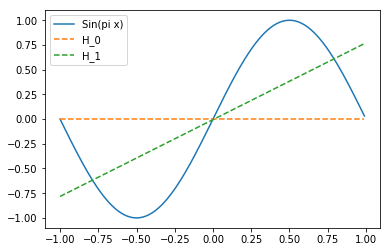

In [148]:
plt.plot(x, y, x, np.repeat(h0_bar, len(x)), '--', x, h1_bar[0] * x + h1_bar[1], '--')
plt.legend(['Sin(pi x)', 'H_0', 'H_1'])

- Variance of H0

0.226105840895


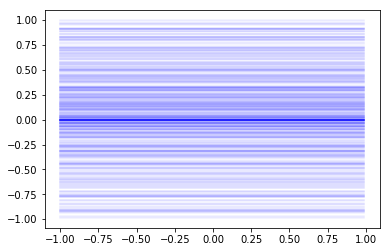

In [153]:
var = []
for i in range(500):
    d_x = np.random.choice(x, 2, replace=True)
    d_y = scipy.sin(np.pi * d_x)
    h0 = np.polyfit(d_x, d_y, deg=0)
    plt.plot(x, np.repeat(h0, len(x)), 'b', alpha=0.06)
    var.append((h0 - h0_bar) ** 2)
plt.plot(x, np.repeat(h0_bar, len(x)), 'b')
print(np.mean(var))

- Variance of H1

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:5: RankWarning: Polyfit may be poorly conditioned
  """
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:5: RankWarning: Polyfit may be poorly conditioned
  """
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:5: RankWarning: Polyfit may be poorly conditioned
  """
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:5: RankWarning: Polyfit may be poorly conditioned
  """
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:5: RankWarning: Polyfit may be poorly conditioned
  """


1.7825423886


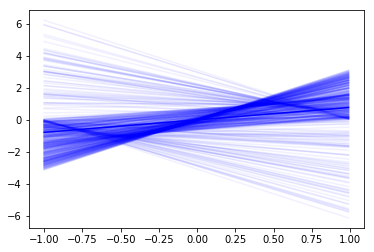

In [154]:
var = []
for i in range(500):
    d_x = np.random.choice(x, 2, replace=True)
    d_y = scipy.sin(np.pi * d_x)
    h1 = np.polyfit(d_x, d_y, deg=1)
    plt.plot(x, h1[0] * x + h1[1], 'b', alpha=0.06)
    pred = h1[0] * x + h1[1]
    var.append((pred - y) ** 2)
plt.plot(x, h1_bar[0] * x + h1_bar[1], 'b')
print(np.mean(var))

## bias + variance of H0 and H1

- H0: 0.5 (bias) + 0.226 (variance) = 0.726
- H1: 0.2 (bias) + 1.783 (variance) = 1.983